In [1]:
import os
import sys
import io
import torch 
import numpy as np
from collections import OrderedDict

%pylab inline
rcParams["figure.figsize"] = (16,5)

import librosa
import librosa.display

from TTS.models.tacotron import Tacotron 
from TTS.layers import *
from TTS.utils.data import *
from TTS.utils.audio import AudioProcessor
from TTS.utils.generic_utils import load_config
from TTS.utils.text import text_to_sequence

import IPython
from IPython.display import Audio

Populating the interactive namespace from numpy and matplotlib


In [2]:
def create_speech(m, s):
    text_cleaner = [CONFIG.text_cleaner]
    seq = np.array(text_to_sequence(s, text_cleaner))
            
#     mel = np.zeros([seq.shape[0], CONFIG.num_mels, 1], dtype=np.float32)
    
    if use_cuda:
        chars_var = torch.autograd.Variable(torch.from_numpy(seq), volatile=True).unsqueeze(0).cuda()
#         mel_var = torch.autograd.Variable(torch.from_numpy(mel).type(torch.cuda.FloatTensor), volatile=True).cuda() 
    else:
        chars_var = torch.autograd.Variable(torch.from_numpy(seq), volatile=True).unsqueeze(0)
#         mel_var = torch.autograd.Variable(torch.from_numpy(mel).type(torch.FloatTensor), volatile=True)
        
    mel_out, linear_out, alignments = model.forward(chars_var)
    linear_out = linear_out[0].data.cpu().numpy()
    alignment = alignments[0].cpu().data.numpy()
    spec = ap._denormalize(linear_out)
    
    wav = ap.inv_spectrogram(linear_out.T)
    wav = wav[:ap.find_endpoint(wav)]
    out = io.BytesIO()
    ap.save_wav(wav, out)
    return wav, alignment, spec


def visualize(alignment, spectrogram):
    label_fontsize = 16
    figure(figsize=(16,16))
    
    subplot(2,1,1)
    imshow(alignment.T, aspect="auto", origin="lower", interpolation=None)
    xlabel("Decoder timestamp", fontsize=label_fontsize)
    ylabel("Encoder timestamp", fontsize=label_fontsize)
    colorbar()

    subplot(2,1,2)
    librosa.display.specshow(spectrogram.T, sr=CONFIG.sample_rate, 
                             hop_length=hop_length, x_axis="time", y_axis="linear")
    xlabel("Time", fontsize=label_fontsize)
    ylabel("Hz", fontsize=label_fontsize)
    tight_layout()
    colorbar()
    
    
def tts(model, text, figures=True):
    waveform, alignment, spectrogram = create_speech(model, text)
    if figures:
        visualize(alignment, spectrogram)
    IPython.display.display(Audio(waveform, rate=CONFIG.sample_rate))

In [3]:
MODEL_PATH = '../result/January-26-2018_02:44AM/checkpoint_1800.pth.tar'
CONFIG_PATH = '../result/January-26-2018_02:44AM/config.json'
OUT_FOLDER = '../result/January-26-2018_02:44AM/test/'
CONFIG = load_config(CONFIG_PATH)
use_cuda = False
hop_length = 250

In [4]:
# load the model
model = Tacotron(CONFIG.embedding_size, CONFIG.hidden_size,
        CONFIG.num_mels, CONFIG.num_freq, CONFIG.r)
ap = AudioProcessor(CONFIG.sample_rate, CONFIG.num_mels, CONFIG.min_level_db,
                         CONFIG.frame_shift_ms, CONFIG.frame_length_ms, CONFIG.preemphasis,
                         CONFIG.ref_level_db, CONFIG.num_freq, CONFIG.power, griffin_lim_iters=80)         

if use_cuda:
    model = torch.nn.DataParallel(model.cuda())
else:
    cp = torch.load(MODEL_PATH, map_location=lambda storage, loc: storage)
    
    # remove DataPatallel wrapper
    new_state_dict = OrderedDict()
    for k, v in cp['model'].items():
        name = k[7:] # remove `module.`
        new_state_dict[name] = v
    cp['model'] = new_state_dict

In [5]:
model.load_state_dict(cp['model'])
# model.decoder.eval();
model.encoder.eval();
model.postnet.eval();

In [6]:
sentences = [
    "I try to speak my friend.",
    "I speak more than binary any more.",
    "I try ti implement a new TTS system."
]

Warning! doesn't seems to be converged


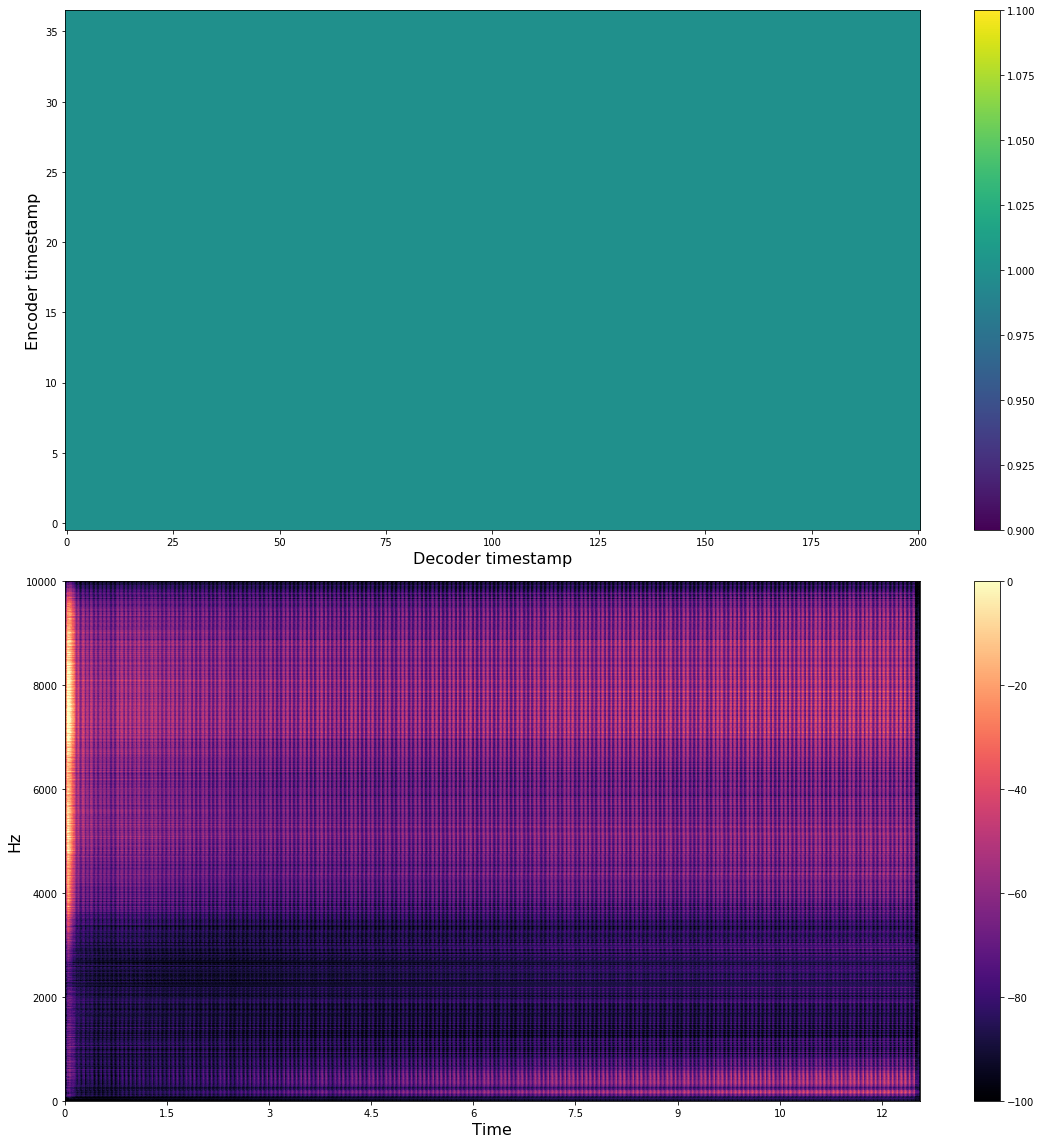

In [7]:
tts(model, sentences[2])

In [8]:
# os.makedirs(OUT_FOLDER, exist_ok=True)

In [9]:
# wav, alignments, spec = create_speech(model, sentences[1])
# out_path = os.path.join(OUT_FOLDER, 'speec_{}.wav'.format(1))
# with open(out_path, "wb") as f:
#     f.write(wav)
# print(" > Speech saved : {}".format(out_path))

In [10]:
# import IPython
# import glob

# # wav_files = glob.glob(OUT_FOLDER+'/**/*.wav', recursive=True)
# # assert len(wav_files) > 0
# # IPython.display.Audio(wav_files[1])
# IPython.display.display(IPython.display.Audio(wav, rate=CONFIG.sample_rate))
